In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/DataIntelligenceApplications/')

---
_Here now check the step3 and step4 with this new environment._

### STEP#3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from environments.complete_environment import CompleteEnvironment
from data_generators.standard_generator import StandardDataGenerator
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB

In [2]:
src = 'src/basic007.json'

In [3]:
dg = StandardDataGenerator(filename=src)
margins = dg.get_margins()

In [4]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 365
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 10


In [5]:
selected_bid = 4

In [6]:
learners_to_test = [ThompsonSampling, UCB]
#learners_to_test = [UCB]
rewards_per_experiment = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []

In [7]:
for e in range(n_experiments):
    print(f'running experiment {e + 1}/{n_experiments}...\n')
    test_instances = []
    for learner in learners_to_test:
        test_instances.append((learner(arm_values=margins),
                               CompleteEnvironment(src=src)))
    for t in range(T):
        for learner, env in test_instances:
            learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            _ = env.get_collected_user_features_at_day(t - 30, keep=False, filter_purchases=True) # past features not usefull here
            month_purchases = env.get_next_purchases_at_day(t, keep=False, filter_purchases=True)
            if month_purchases is not None:
                for arm, n_purchases in zip(past_arms, month_purchases):
                    learner.update_single_future_purchase(arm, n_purchases)
            pulled_arm = learner.pull_arm()
            daily_reward, _, _ = env.day_round(pulled_arm, selected_bid=selected_bid, fixed_adv=True)
            for outcome, cost in daily_reward:
                learner.update(pulled_arm, outcome, cost)
    for learner, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.LEARNER_NAME].append(learner.daily_collected_rewards)

running experiment 1/10...

running experiment 2/10...

running experiment 3/10...

running experiment 4/10...

running experiment 5/10...

running experiment 6/10...

running experiment 7/10...

running experiment 8/10...

running experiment 9/10...

running experiment 10/10...



In [8]:
margins = dg.get_margins()
classes = dg.get_classes()
conversion_rates = dg.get_conversion_rates(mode='all')
future_purchases = dg.get_future_purchases(mode='all')
number_of_clicks = dg.get_daily_clicks(mode='all')

costs_per_click = dg.get_costs_per_click(mode='aggregate', bid=selected_bid)
fixed_cost = costs_per_click[selected_bid]
fixed_n_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[selected_bid]).astype(int)
fractions = dg.get_class_distributions(selected_bid)

temp = (margins * np.average(conversion_rates * (1 + future_purchases),
                             axis=0,
                             weights=fractions) - fixed_cost) * fixed_n_clicks
aggr_opt_arm = np.argmax(temp)
aggr_opt = np.max(temp)

disaggr_opt = 0
opt_arms = []
disaggr_costs = dg.get_costs_per_click(mode='all')
for i, _ in enumerate(conversion_rates):
    t = (margins * conversion_rates[i] * (1 + future_purchases[i]) - disaggr_costs[i, selected_bid]) * \
                number_of_clicks[i, selected_bid]
    opt_arm = np.argmax(t)
    opt_value = np.max(t)
    opt_arms.append(opt_arm)
    disaggr_opt += opt_value

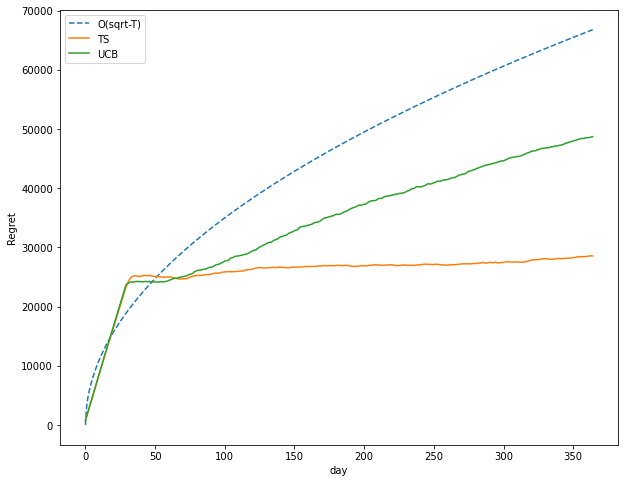

In [9]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(3500*np.sqrt(np.linspace(0,364,365)), '--')
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(aggr_opt - val, axis=0)))


#plt.axvline(x=cg_start_from, color='r', linestyle='--')
#for val in days_of_split.values():
#    avg_days = np.mean(val, axis=0)
#    for day in avg_days:
#        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(['O(sqrt-T)']+list(rewards_per_experiment.keys()))
plt.show()

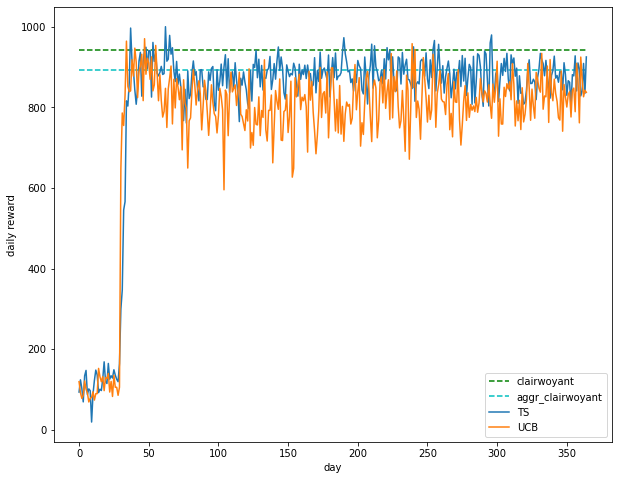

In [10]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

plt.legend(loc='best')
plt.show()

---
### STEP#4

In [11]:
from learners.pricing.contextual_learner import ContextualLearner
from utils.context_generator import ContextGenerator

In [12]:
selected_bid = 4
T = 365
n_experiments = 10
learners_to_test = [ThompsonSampling, UCB]
cg_start_from = 60
cg_confidence = 0.02
cg_frequency = 10

features = dg.get_features() 
fractions = dg.get_class_distributions(selected_bid)
bandit_args = {
            'arm_values': dg.get_margins()
}

In [13]:
rewards_per_experiment = {}
context_split_per_experiment = {}
days_of_split = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_per_experiment[learner.LEARNER_NAME] = []
    days_of_split[learner.LEARNER_NAME] = []

In [14]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'\nrunning experiment {e + 1}/{n_experiments}...\n')
    test_instances = []
    
    for learner in learners_to_test:
        context_learner = ContextualLearner(features, learner, **bandit_args)
        test_instances.append(
            (context_learner,
             CompleteEnvironment(src=src),
             ContextGenerator(features=features,
                              contextual_learner=context_learner,
                              update_frequency=cg_frequency,
                              start_from=cg_start_from,
                              confidence=cg_confidence,
                              verbose=1))
        )
    for t in range(T):
        for context_learner, env, context_generator in test_instances:
            #print(f'##### DAY {t} ######')
            context_learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            past_features = env.get_collected_user_features_at_day(t - 30, keep=False, filter_purchases=True)
            month_purchases = env.get_next_purchases_at_day(t, keep=True, filter_purchases=True)
            if month_purchases is not None:
                context_learner.update_next_purchases(past_arms, month_purchases, past_features)

            pulled_arms = context_learner.pull_arms()
            daily_rewards, _, _ = env.day_round(pulled_arms, selected_bid=selected_bid, fixed_adv=True)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)
            
            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, 
                                                 daily_rewards, 
                                                 daily_users_features,
                                                 next_purchases=month_purchases, 
                                                 past_pulled_arms=past_arms,
                                                 past_features=past_features)
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())
        days_of_split[learner.base_learner_class.LEARNER_NAME].append(context_generator.metadata['SPLIT_DAYS'])
    
    # end -> save rhe results.


running experiment 1/10...


-------------------- RUNNING CONTEXT GENERATOR@t=60 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']

Analysis of the feature `feature-1`...

Analysis of the feature `feature-2`...
	Values after the split: [3.3306574088903984, 3.2907086552723053]
	Value before the split: 3.1778412640604192

	"Best feature: "feature-1
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': False} and {'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=60 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']

Analysis of the feature `feature-1`...

Analysis of the feature `feature-2`...
	Values after the split: [3.0599628813095903, 2.779847235574962]
	Value before the split: 1.7682052428611716

	"Best feature: "feature-1
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': Fa

	Values after the split: [1.2618937835088095]
	Value before the split: 1.3061883843565105


-------------------- RUNNING CONTEXT GENERATOR@t=150 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.2557033195062335]
	Value before the split: 1.3002559393878872


-------------------- RUNNING CONTEXT GENERATOR@t=160 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.2701223040947194]
	Value before the split: 1.314983548472437


-------------------- RUNNING CONTEXT GENERATOR@t=170 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Valu

	Values after the split: [4.094681460070552]
	Value before the split: 5.339786898107728


-------------------- RUNNING CONTEXT GENERATOR@t=80 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.2739170579936907]
	Value before the split: 1.3028922000739342

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [5.115245378608184]
	Value before the split: 5.064820077792887

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': True, 'feature-2': False} and {'feature-1': True, 'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=80 [UCB]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['f

	Values after the split: [1.2828122967871813]
	Value before the split: 1.3163716838090949


-------------------- RUNNING CONTEXT GENERATOR@t=270 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.2868597597473723]
	Value before the split: 1.3198077669051849


-------------------- RUNNING CONTEXT GENERATOR@t=280 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.2857596802537063]
	Value before the split: 1.3181661207485524


-------------------- RUNNING CONTEXT GENERATOR@t=290 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Val

	Values after the split: [1.2247514258326335]
	Value before the split: 1.2805353858426973

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.312755856338874]
	Value before the split: 5.33154798786654


-------------------- RUNNING CONTEXT GENERATOR@t=100 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [0.6263771682984803]
	Value before the split: 1.3328807782931138


-------------------- RUNNING CONTEXT GENERATOR@t=110 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [1.247053648272249]
	Value before the split: 1.3012606075618598

- Evalua

	Values after the split: [5.2239728915721635]
	Value before the split: 5.233052379071425


-------------------- RUNNING CONTEXT GENERATOR@t=190 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [0.77341811191249]
	Value before the split: 1.3616957369417664


-------------------- RUNNING CONTEXT GENERATOR@t=200 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [1.305755511289778]
	Value before the split: 1.3459738037316855

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.231170533182144]
	Value before the split: 5.237504260803752


---------

	Values after the split: [1.3135194798310674]
	Value before the split: 1.3329077811848618


-------------------- RUNNING CONTEXT GENERATOR@t=300 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [0.6399538409798251]
	Value before the split: 1.345773538192026


-------------------- RUNNING CONTEXT GENERATOR@t=310 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [1.312092149990918]
	Value before the split: 1.3314580239642515


-------------------- RUNNING CONTEXT GENERATOR@t=310 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Val

	Values after the split: [0.8347265168858]
	Value before the split: 1.4002944267558803

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [4.481524905685796]
	Value before the split: 3.2967085323117886

	"Best feature: "feature-1
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': True, 'feature-1': False} and {'feature-2': True, 'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=100 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [5.172681717583414]
	Value before the split: 5.274173917787391


-------------------- RUNNING CONTEXT GENERATOR@t=100 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['fe


Analysis of the feature `feature-2`...
	Values after the split: [2.9252678905945593, 3.042705616659183]
	Value before the split: 2.9713896259632

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': False} and {'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=70 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']

Analysis of the feature `feature-1`...

Analysis of the feature `feature-2`...
	Values after the split: [3.0702264967184343, 3.111265612275994]
	Value before the split: 3.1539576870420447


-------------------- RUNNING CONTEXT GENERATOR@t=70 [UCB]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [0.8264702164738624]
	Value before the split: 1.3282916242191765

- Evaluating the Node:

	Values after the split: [1.5451874827608967]
	Value before the split: 1.6299890859109663

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.0720311527361295]
	Value before the split: 5.083867453563439


-------------------- RUNNING CONTEXT GENERATOR@t=90 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [4.0889518309035]
	Value before the split: 4.746271522882478


-------------------- RUNNING CONTEXT GENERATOR@t=100 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [1.4032567021741764]
	Value before the split: 1.406120476087026

- Evaluating

	Values after the split: [5.107245303187413]
	Value before the split: 5.117051951443784


-------------------- RUNNING CONTEXT GENERATOR@t=280 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.103736619695829]
	Value before the split: 5.1194570143925455


-------------------- RUNNING CONTEXT GENERATOR@t=290 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.09394693823003]
	Value before the split: 5.117808307139876


-------------------- RUNNING CONTEXT GENERATOR@t=300 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after


-------------------- RUNNING CONTEXT GENERATOR@t=150 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.001410499562217]
	Value before the split: 5.060952454066784


-------------------- RUNNING CONTEXT GENERATOR@t=160 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [4.997010349217488]
	Value before the split: 5.061538249285153


-------------------- RUNNING CONTEXT GENERATOR@t=170 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.010915178146397]
	Value before the split: 5.078401776333112


------------


-------------------- RUNNING CONTEXT GENERATOR@t=70 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.1570909812642909]
	Value before the split: 1.2057037609746033

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [5.128884965659183]
	Value before the split: 5.038917141718337

	"Best feature: "feature-2
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': True, 'feature-2': False} and {'feature-1': True, 'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=70 [UCB]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [0.5447010058

	Values after the split: [0.6167889432442679]
	Value before the split: 1.2878334375986238


-------------------- RUNNING CONTEXT GENERATOR@t=180 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.3033371477027258]
	Value before the split: 1.3459722342842266


-------------------- RUNNING CONTEXT GENERATOR@t=180 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [0.5735847742279907]
	Value before the split: 0.5254170993515154

	"Best feature: "feature-1
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': False, 'feature-1': False} and {'feature-2': False, 'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=190 [TS]--------------------
N_LEAVES: 1

	Values after the split: [0.8975852666470092]
	Value before the split: 1.3986080350154717

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.066524000223331]
	Value before the split: 5.140138631057298


-------------------- RUNNING CONTEXT GENERATOR@t=80 [TS]--------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.3017394809736602]
	Value before the split: 1.353604605740439

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [4.888571540002329]
	Value before the split: 5.00155765679125


-------------------- RUNNING CONTEXT GENERATOR@t=80 [UCB]--------------------
N_LEAVES: 2
- Evaluating 

	Values after the split: [0.5147681967495696]
	Value before the split: 1.3543445439047292


-------------------- RUNNING CONTEXT GENERATOR@t=170 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.2849819355368555]
	Value before the split: 1.290244413733438


-------------------- RUNNING CONTEXT GENERATOR@t=170 [UCB]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [0.5158722547498485]
	Value before the split: 1.2908737555804983


-------------------- RUNNING CONTEXT GENERATOR@t=180 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Val

	Values after the split: [1.257087275266933]
	Value before the split: 1.3059750298322896


-------------------- RUNNING CONTEXT GENERATOR@t=130 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.2697882483274348]
	Value before the split: 1.318363384193114


-------------------- RUNNING CONTEXT GENERATOR@t=140 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [1.2697556708409299]
	Value before the split: 1.317932106470594


-------------------- RUNNING CONTEXT GENERATOR@t=150 [TS]--------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']

Analysis of the feature `feature-2`...
	Values

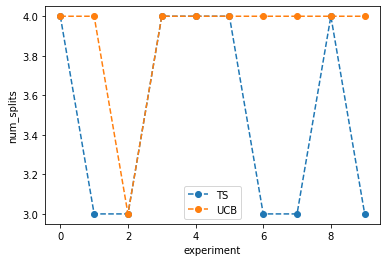

In [15]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_per_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_per_experiment.keys())
plt.show()

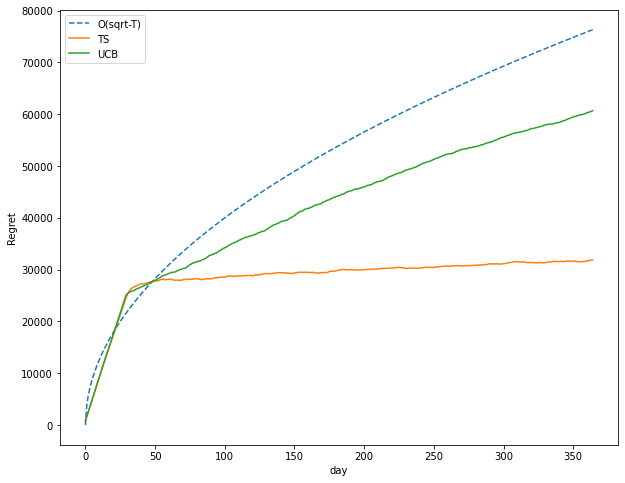

In [16]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(4000*np.sqrt(np.linspace(0,364,365)), '--')
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(disaggr_opt - val, axis=0)))

plt.legend(['O(sqrt-T)']+list(rewards_per_experiment.keys()))
plt.show()

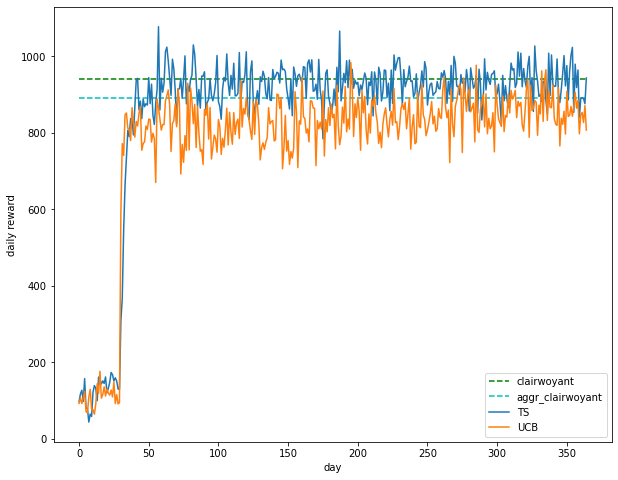

In [17]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

plt.legend(loc='best')
plt.show()